This project for answering the business questions using SQL by dataquest.

Using the chinook database and the data table inside this database to answering questions from Management and Business team.



# Chinook: SQL Analysis of digital music store data

In this project, we'll work with data from the Chinook, a fictional digital music store.

The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store. It contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables.

Check our database:

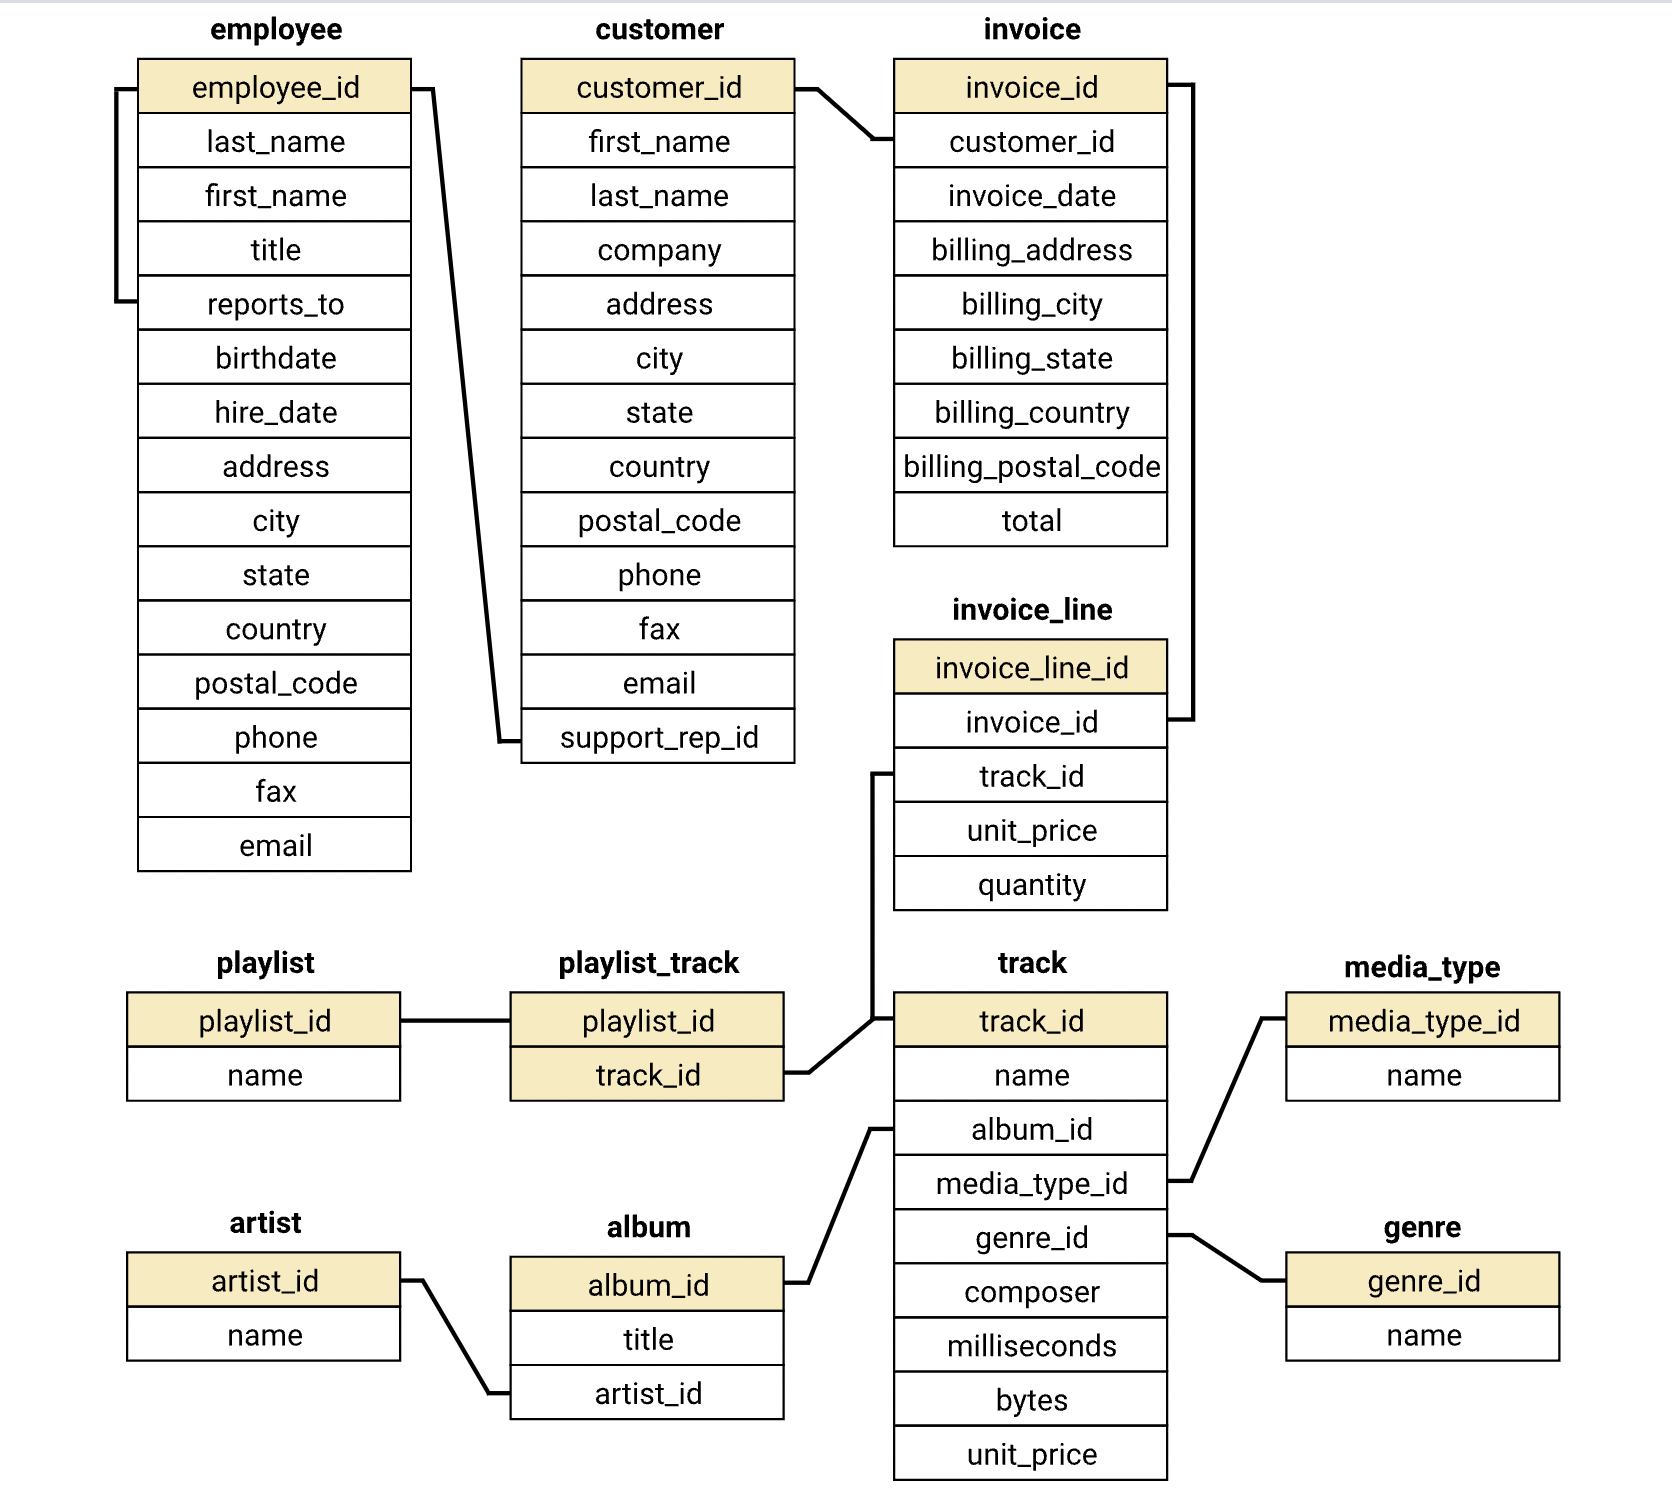

In [1]:
from IPython.display import Image
Image(filename='./images/chinook-database.png')

## Prepare the function to help in this notebook

In [2]:
# !cd chinook-unmodified.db chinook.db

In [3]:
# !pip3 install colorspacious

In [4]:
!pip3 install sql

In [12]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
# from colorspacious import cspace_converter
%matplotlib inline

db = './database/chinook.db' # define a variable for database name 

In [19]:
%%capture
%load_ext sql
%sql sqlite:///./database/chinook.db

In [7]:
# Create function that takes a SQL query as an argument
# Then returns a pandas dataframe of that query

def run_query(q): # q stand for query
    with sqlite3.connect(db) as conn: # conn stand for connect
        return pd.read_sql(q, conn)

In [8]:
# Create function that takes a SQL command as an argument
# Then executes it using the sqlite modele
def run_command(c): # c stand for SQL command
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

In [14]:
# Create function that calls the run_query() function 
# Return a list of all tables and views in the database
def show_tables():
    # SQL statement
    q = '''
    SELECT 
           name,
           type
      FROM sqlite_master
     WHERE type IN ("table", "view");
     '''
    return run_query(q)

In [15]:
# Show all table in the database
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
...,...,...
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting New Albums to Purchase

Selecting the new albums that we should to purchase from the number of track in the USA.

The Chinook record store has just signed a deal with a new record label, and we want to understand the first three albums that will be added to the store, from a list of four.

The record label specialises in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

All four albums are by artists that don't have any tracks in the store right now - We have the artist names, and the genre of music they produce:

Let's find out which genres sell the most tracks in the USA.

<img src="./images/baseline-data.png" alt="Artist & Genre">

### PYTHON VERSION

In [16]:
recommended_albums = '''
WITH usa_most_track AS 
    (
     SELECT il.*
       FROM invoice_line AS il
      INNER JOIN invoice AS i
         ON il.invoice_id = i.invoice_id
      INNER JOIN customer AS c
         ON i.customer_id = c.customer_id
      WHERE c.country = 'USA'
    )
    
SELECT 
       g.name AS genre,
       COUNT(umt.invoice_line_id) AS num_track_sold,
       ROUND(CAST(COUNT(umt.invoice_line_id) AS FLOAT) / (
           SELECT COUNT(*)
             FROM usa_most_track), 6) AS per_track_sold
  FROM usa_most_track AS umt
 INNER JOIN track AS t
    ON t.track_id = umt.track_id
 INNER JOIN genre AS g
    ON g.genre_id = t.genre_id
 GROUP BY genre
 ORDER BY num_track_sold DESC
 LIMIT 10; 
'''
# Create view for the most track in the USA by join with 3 tables from invoice and customer with invoince_line table
# Use the view that we created above for join with track table and genre table to find the top 5 track that sold in USA
# Group the result by genre and sorted by number of track that sold in the USA 
run_query(recommended_albums)

,genre,num_track_sold,per_track_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Pop,22,0.020932
7,Latin,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


In [17]:
recommended_artist = '''
WITH usa_most_track AS
    (
     SELECT il.*
       FROM invoice_line AS il
      INNER JOIN invoice AS i
         ON il.invoice_id = i.invoice_id
      INNER JOIN customer AS c
         ON i.customer_id = c.customer_id
      WHERE c.country = 'USA'
    ),
    artist_info AS
    (
     SELECT t.track_id, t.album_id,
            ab.*, 
            a.name AS artist_name
       FROM track AS t
      INNER JOIN album AS ab
         ON t.album_id = ab.album_id
      INNER JOIN artist as a
         ON ab.artist_id = a.artist_id
    )
    
SELECT 
       at.artist_name,
       g.name AS genre,
       COUNT(umt.invoice_line_id) AS num_track_sold,
       ROUND(CAST(COUNT(umt.invoice_line_id) AS FLOAT) / (
           SELECT COUNT(*)
             FROM usa_most_track), 6) AS per_track_sold
  FROM usa_most_track AS umt
 INNER JOIN track AS t
    ON t.track_id = umt.track_id
 INNER JOIN genre AS g
    ON g.genre_id = t.genre_id
 INNER JOIN artist_info AS at
    ON at.track_id = umt.track_id
 GROUP BY 1
HAVING (genre = 'R&B/Soul') OR (genre = 'Alternative & Punk') OR (genre = 'Blues') OR (genre = 'Metal')
 ORDER BY num_track_sold DESC
 LIMIT 10; 
'''

# Create another view that to find the artist name by join 3 tables together as above
# Use the new view to find the artist from the genre that we should inspect
# -to check whose artists are the most number of tracks that sold in the USA in the genre that we have interested in and want to purchase
run_query(recommended_artist)

,artist_name,genre,num_track_sold,per_track_sold
0,R.E.M.,Alternative & Punk,38,0.036156
1,Eric Clapton,Blues,34,0.032350
2,Green Day,Alternative & Punk,32,0.030447
3,Pearl Jam,Alternative & Punk,31,0.029496
4,Amy Winehouse,R&B/Soul,30,0.028544
5,Marvin Gaye,R&B/Soul,26,0.024738
6,Black Sabbath,Metal,24,0.022835
7,System Of A Down,Metal,22,0.020932
8,Godsmack,Metal,20,0.019029
9,Os Mutantes,Alternative & Punk,19,0.018078


### SQL VERSION

In [20]:
%%sql

WITH usa_most_track AS 
    (
     SELECT il.*
       FROM invoice_line AS il
      INNER JOIN invoice AS i
         ON il.invoice_id = i.invoice_id
      INNER JOIN customer AS c
         ON i.customer_id = c.customer_id
      WHERE c.country = 'USA'
    )
    
SELECT 
       g.name AS genre,
       COUNT(umt.invoice_line_id) AS num_track_sold,
       ROUND(CAST(COUNT(umt.invoice_line_id) AS FLOAT) / (
           SELECT COUNT(*)
             FROM usa_most_track), 6) AS per_track_sold
  FROM usa_most_track AS umt
 INNER JOIN track AS t
    ON t.track_id = umt.track_id
 INNER JOIN genre AS g
    ON g.genre_id = t.genre_id
 GROUP BY 1
 ORDER BY num_track_sold DESC
 LIMIT 5;

 * sqlite:///./database/chinook.db
   sqlite:///chinook.db
Done.


genre,num_track_sold,per_track_sold
Rock,561,0.533777
Alternative & Punk,130,0.123692
Metal,124,0.117983
R&B/Soul,53,0.050428
Blues,36,0.034253


In [21]:
%%sql
WITH usa_most_track AS
    (
     SELECT il.*
       FROM invoice_line AS il
      INNER JOIN invoice AS i
         ON il.invoice_id = i.invoice_id
      INNER JOIN customer AS c
         ON i.customer_id = c.customer_id
      WHERE c.country = 'USA'
    ),
    artist_info AS
    (
     SELECT t.track_id, t.album_id,
            ab.*, 
            a.name AS artist_name
       FROM track AS t
      INNER JOIN album AS ab
         ON t.album_id = ab.album_id
      INNER JOIN artist as a
         ON ab.artist_id = a.artist_id
    )
    
SELECT 
       at.artist_name,
       g.name AS genre,
       COUNT(umt.invoice_line_id) AS num_track_sold,
       ROUND(CAST(COUNT(umt.invoice_line_id) AS FLOAT) / (
           SELECT COUNT(*)
             FROM usa_most_track), 6) AS per_track_sold
  FROM usa_most_track AS umt
 INNER JOIN track AS t
    ON t.track_id = umt.track_id
 INNER JOIN genre AS g
    ON g.genre_id = t.genre_id
 INNER JOIN artist_info AS at
    ON at.track_id = umt.track_id
 GROUP BY 1
HAVING (genre = 'R&B/Soul') OR (genre = 'Alternative & Punk') OR (genre = 'Blues') OR (genre = 'Metal')
 ORDER BY num_track_sold DESC
 LIMIT 10;

 * sqlite:///./database/chinook.db
   sqlite:///chinook.db
Done.


artist_name,genre,num_track_sold,per_track_sold
R.E.M.,Alternative & Punk,38,0.036156
Eric Clapton,Blues,34,0.03235
Green Day,Alternative & Punk,32,0.030447
Pearl Jam,Alternative & Punk,31,0.029496
Amy Winehouse,R&B/Soul,30,0.028544
Marvin Gaye,R&B/Soul,26,0.024738
Black Sabbath,Metal,24,0.022835
System Of A Down,Metal,22,0.020932
Godsmack,Metal,20,0.019029
Os Mutantes,Alternative & Punk,19,0.018078


### Visualization and Analysis

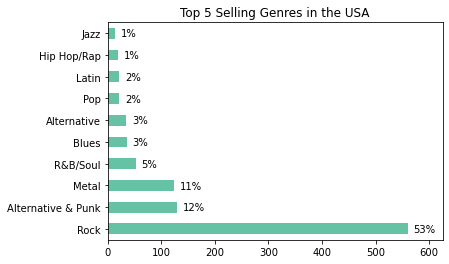

In [22]:
recom_in_usa = run_query(recommended_albums)
recom_in_usa.set_index("genre", inplace=True, drop=True)

recom_in_usa["num_track_sold"].plot.barh(
    title="Top 5 Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Set2
)

plt.ylabel('')

for i, label in enumerate(list(recom_in_usa.index)):
    score = recom_in_usa.loc[label, "num_track_sold"]
    label = (recom_in_usa.loc[label, "per_track_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

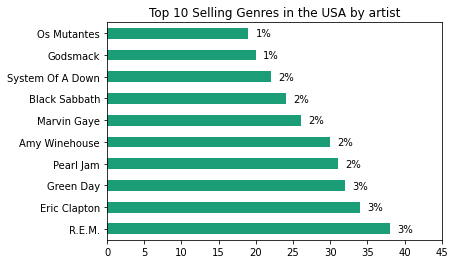

In [23]:
recom_art_in_usa = run_query(recommended_artist)
recom_art_in_usa.set_index("artist_name", inplace=True, drop=True)

recom_art_in_usa["num_track_sold"].plot.barh(
    title="Top 10 Selling Genres in the USA by artist",
    xlim=(0, 45),
    colormap=plt.cm.Dark2
)

plt.ylabel('')

for i, label in enumerate(list(recom_art_in_usa.index)):
    score = recom_art_in_usa.loc[label, "num_track_sold"]
    label = (recom_art_in_usa.loc[label, "per_track_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 1, i - 0.15))

plt.show()

From the graph above that based on the sales of tracks across different genres in the USA, We found that the " Rock "
is the most top-selling genre in the USA and proportion in marketing is quite a lot if we compare with other genre in top 5 as above.

Therefore, we should support other genres that have the growing trend in a good way. we should purchase the new albums by the following artists:

- R.E.M. (Alternative & Punk)
- Eric Clapton (Blues)
- Green day (Alternative & Punk)
- Pearl Jam (Alternative & Punk)
- Amy Winehouse (R&B/Soul)
- Marvin Gaye (R&B/Soul)
- Black Sabbath (Metal)
- System Of A Down M (Metal)
- Godsmack (Metal)
- Os Mutantes (Alternative & Punk)

But for the most 3 artist that I can suggest to purchase the new albums as the below list:

- Green day (Alternative & Punk)
- Amy Winehouse (R&B/Soul)
- Black Sabbath (Metal)

The 3 artist above have the most the number of track from the USA and the proportion of market are 30%, 28% and 22% from thier genre respectively


#### BUT

As the new signed for the Chinook with the new record label. They want to understand the first three albums that will be added to the store, from a list of four(the earlier image that I shown). 

"All four albums are by artists that don't have any tracks in the store right now - We have the artist names, and the genre of music they produce"

Taking this for our case to choose 3 out of the 4 artists - We should leave Hip-Hop genre artist behind, and go with
- Red Tone 
- Meteor and the Girls
- and Slim Jim Bites.

It's worth keeping in mind that combined, these 3 genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

---------------------------------------------------------------------------------------------------------------------

## Analyzing Employee Sales Performance

finds the total dollar amount of sales assigned to each sales support agent within the company.

### PYTHON VERSION

In [24]:
employee_overall = '''
SELECT *
  FROM employee
 LIMIT 5;
'''

# Run the query with first five rows, all column to check overall in this table
run_query(employee_overall)

,employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
0,1,Adams,Andrew,General Manager,NaN,1962-02-18 00:00:00,2016-08-14 00:00:00,11120 Jasper Ave NW,Edmonton,AB,Canada,T5K 2N1,+1 (780) 428-9482,+1 (780) 428-3457,andrew@chinookcorp.com
1,2,Edwards,Nancy,Sales Manager,1.0,1958-12-08 00:00:00,2016-05-01 00:00:00,825 8 Ave SW,Calgary,AB,Canada,T2P 2T3,+1 (403) 262-3443,+1 (403) 262-3322,nancy@chinookcorp.com
2,3,Peacock,Jane,Sales Support Agent,2.0,1973-08-29 00:00:00,2017-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com
3,4,Park,Margaret,Sales Support Agent,2.0,1947-09-19 00:00:00,2017-05-03 00:00:00,683 10 Street SW,Calgary,AB,Canada,T2P 5G3,+1 (403) 263-4423,+1 (403) 263-4289,margaret@chinookcorp.com
4,5,Johnson,Steve,Sales Support Agent,2.0,1965-03-03 00:00:00,2017-10-17 00:00:00,7727B 41 Ave,Calgary,AB,Canada,T3B 1Y7,1 (780) 836-9987,1 (780) 836-9543,steve@chinookcorp.com


From employee table we found the following properties as below:

- employee_id 
- last_name
- first_name
- title
- reports_to
- birthdate
- hire_date
- address
- city
- state
- country
- postal_code
- phone 
- fax
- email

As the list of column names above, we know that "hire_date" and "total_sales" can be the properties that tell me about the performance of each employee.

In [25]:
employee_sales_performance = '''
WITH customer_support_rep_sales AS
    (
     SELECT
            i.customer_id,
            c.support_rep_id,
            SUM(i.total) AS total
       FROM invoice AS i
      INNER JOIN customer AS c 
         ON i.customer_id = c.customer_id
      GROUP BY 1,2
    )

SELECT
       e.first_name || " " || e.last_name AS employee,
       e.hire_date,
       e.title AS title,
       SUM(csrs.total) AS total_sales
  FROM customer_support_rep_sales AS csrs
 INNER JOIN employee AS e 
    ON e.employee_id = csrs.support_rep_id
 GROUP BY 1;
'''
# Create view to find the employee that support the customer 
# Use the view to inspect the employee's performance since their hired date 
# -and the total amount of sales that the employee got from their customer.
run_query(employee_sales_performance)

,employee,hire_date,title,total_sales
0,Jane Peacock,2017-04-01 00:00:00,Sales Support Agent,1731.51
1,Margaret Park,2017-05-03 00:00:00,Sales Support Agent,1584.00
2,Steve Johnson,2017-10-17 00:00:00,Sales Support Agent,1393.92


### SQL VERSION

In [26]:
%%sql
SELECT *
  FROM employee
 LIMIT 5;

 * sqlite:///./database/chinook.db
   sqlite:///chinook.db
Done.


employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
1,Adams,Andrew,General Manager,None,1962-02-18 00:00:00,2016-08-14 00:00:00,11120 Jasper Ave NW,Edmonton,AB,Canada,T5K 2N1,+1 (780) 428-9482,+1 (780) 428-3457,andrew@chinookcorp.com
2,Edwards,Nancy,Sales Manager,1,1958-12-08 00:00:00,2016-05-01 00:00:00,825 8 Ave SW,Calgary,AB,Canada,T2P 2T3,+1 (403) 262-3443,+1 (403) 262-3322,nancy@chinookcorp.com
3,Peacock,Jane,Sales Support Agent,2,1973-08-29 00:00:00,2017-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com
4,Park,Margaret,Sales Support Agent,2,1947-09-19 00:00:00,2017-05-03 00:00:00,683 10 Street SW,Calgary,AB,Canada,T2P 5G3,+1 (403) 263-4423,+1 (403) 263-4289,margaret@chinookcorp.com
5,Johnson,Steve,Sales Support Agent,2,1965-03-03 00:00:00,2017-10-17 00:00:00,7727B 41 Ave,Calgary,AB,Canada,T3B 1Y7,1 (780) 836-9987,1 (780) 836-9543,steve@chinookcorp.com


In [27]:
%%sql
WITH customer_support_rep_sales AS
    (
     SELECT
            i.customer_id,
            c.support_rep_id,
            SUM(i.total) AS total
       FROM invoice AS i
      INNER JOIN customer AS c 
         ON i.customer_id = c.customer_id
      GROUP BY 1,2
    )

SELECT
       e.first_name || " " || e.last_name AS employee,
       e.hire_date,
       e.title AS title,
       ROUND(SUM(csrs.total), 2) AS total_sales
  FROM customer_support_rep_sales AS csrs
 INNER JOIN employee AS e 
    ON e.employee_id = csrs.support_rep_id
 GROUP BY 1;

 * sqlite:///./database/chinook.db
   sqlite:///chinook.db
Done.


employee,hire_date,title,total_sales
Jane Peacock,2017-04-01 00:00:00,Sales Support Agent,1731.51
Margaret Park,2017-05-03 00:00:00,Sales Support Agent,1584.0
Steve Johnson,2017-10-17 00:00:00,Sales Support Agent,1393.92


### Visualization and Analysis

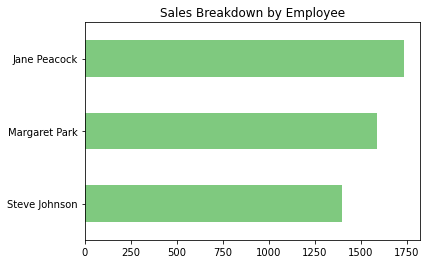

In [28]:
employee_sales = run_query(employee_sales_performance)

employee_sales.set_index("employee", drop=True, inplace=True)
employee_sales.sort_values("total_sales", inplace=True)
employee_sales.plot.barh(
    legend=False,
    title='Sales Breakdown by Employee',
    colormap=plt.cm.Accent
)
plt.ylabel('')
plt.show()


While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates.

---------------------------------------------------------------------------------------------------------------------

## Analyzing Sales by Country

Analyze the sales data for customers from each different country.

We are required to analyse the sales data for customers from each different country and present it sorted by Total Sales Value so that we can sales by countries from highest to lowest.

In particular, we have been directed to calculate data, for each country, on the:

- Total number of customers
- Total value of sales
- Average value of sales per customer
- Average order value

Note: Because there are a number of countries with only one customer, we are asked to group these customers as "Other" in result and make that as the last record.

Because there are a number of countries with only one customer, Group these customers as "Other" together will help this analysis easier.

### PYTHON VERSION

In [29]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
            CASE
                WHEN (
                      SELECT count(*)
                        FROM customer
                       WHERE country = c.country
                     ) = 1 THEN "Other"
                ELSE c.country
            END AS country,
            c.customer_id,
            il.*
       FROM invoice_line AS  il
      INNER JOIN invoice AS i 
         ON i.invoice_id = il.invoice_id
      INNER JOIN customer AS c 
         ON c.customer_id = i.customer_id
    )

SELECT
       country,
       customers,
       total_sales,
       average_order,
       customer_lifetime_value
  FROM
    (
    SELECT
           country,
           COUNT(DISTINCT customer_id) AS customers,
           SUM(unit_price) AS total_sales,
           ROUND(SUM(unit_price) / COUNT(DISTINCT(customer_id)), 2) AS customer_lifetime_value,
           ROUND(SUM(unit_price) / COUNT(DISTINCT(invoice_id)), 2) AS average_order,
           CASE
                WHEN country = "Other" THEN 1
                ELSE 0
           END AS sort
      FROM country_or_other
     GROUP BY country
     ORDER BY sort ASC, total_sales DESC
    );
'''
# Create the country_or_other view to group the country that have only one customer with "Other". Otherwise still the same.
# Use the view as table to create subquery for calculate "total sales", "customer lifetimve value" and "average of order"
# Group data by country.
# Use one of the subquery to filtered the country that has one customer as sorted by ascending order.
# finally sorted the "total sales by descending order to see which countries are the most from total sales.
run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.94,80.04
1,Canada,8,535.59,7.05,66.95
2,Brazil,5,427.68,7.01,85.54
3,France,5,389.07,7.78,77.81
4,Germany,4,334.62,8.16,83.66
5,Czech Republic,2,273.24,9.11,136.62
6,United Kingdom,3,245.52,8.77,81.84
7,Portugal,2,185.13,6.38,92.57
8,India,2,183.15,8.72,91.58
9,Other,15,1094.94,7.45,73.00


### SQL VERSION

In [30]:
%%sql
WITH country_or_other AS
    (
     SELECT
            CASE
                WHEN (
                      SELECT count(*)
                        FROM customer
                       WHERE country = c.country
                     ) = 1 THEN "Other"
                ELSE c.country
            END AS country,
            c.customer_id,
            il.*
       FROM invoice_line AS  il
      INNER JOIN invoice AS i 
         ON i.invoice_id = il.invoice_id
      INNER JOIN customer AS c 
         ON c.customer_id = i.customer_id
    )

SELECT
       country,
       customers,
       total_sales,
       average_order,
       customer_lifetime_value
  FROM
    (
    SELECT
           country,
           COUNT(DISTINCT customer_id) AS customers,
           ROUND(SUM(unit_price), 2) AS total_sales,
           ROUND(SUM(unit_price) / COUNT(DISTINCT(customer_id)), 2) AS customer_lifetime_value,
           ROUND(SUM(unit_price) / COUNT(DISTINCT(invoice_id)), 2) AS average_order,
           CASE
                WHEN country = "Other" THEN 1
                ELSE 0
           END AS sort
      FROM country_or_other
     GROUP BY country
     ORDER BY sort ASC, total_sales DESC
    );

 * sqlite:///./database/chinook.db
   sqlite:///chinook.db
Done.


country,customers,total_sales,average_order,customer_lifetime_value
USA,13,1040.49,7.94,80.04
Canada,8,535.59,7.05,66.95
Brazil,5,427.68,7.01,85.54
France,5,389.07,7.78,77.81
Germany,4,334.62,8.16,83.66
Czech Republic,2,273.24,9.11,136.62
United Kingdom,3,245.52,8.77,81.84
Portugal,2,185.13,6.38,92.57
India,2,183.15,8.72,91.58
Other,15,1094.94,7.45,73.0


### Visualizing Sales by Country

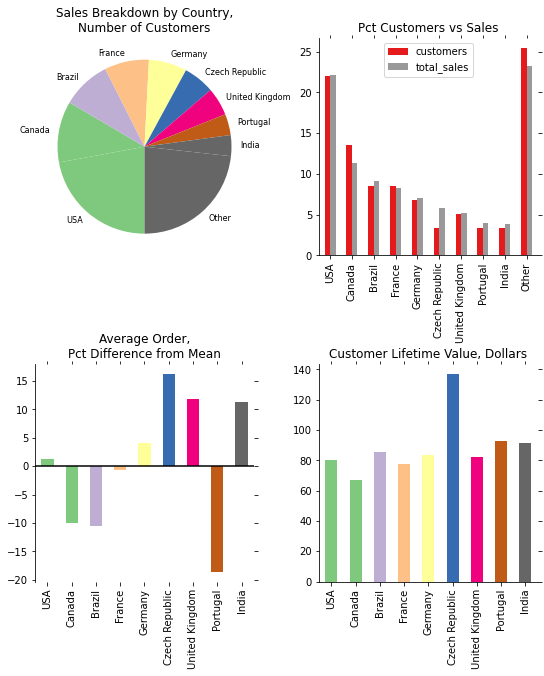

In [31]:
country_metrics = run_query(sales_by_country) # Run query function and assign to a new variable
country_metrics.set_index("country", drop=True, inplace=True) # Change country column to index column
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])] # Change color by number of country

# Create subplot as 2x2 
# Define each axes and and size
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10)) 
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
# Inspect sales breakdown into each country and number of customers.
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
# Comparing between proportion from customer and sales in each country.
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
# Average order as percentage that difference from mean.
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
# Customer lifetime value and their spend from each country.
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

### Analysis

Based on the data, 

US and Canada (North America) score high on total customers by sales
However, by Average Customer Sales Value, Czech Republic, UK and India score high

there may be opportunity in the following countries:

- Czech Republic
- United Kingdom
- India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

## In this visualization and analysis, I have a reference from the guide solution. because this is similar to my query result and this is quite a beautiful graph 

For refer: https://github.com/dataquestio/solutions/blob/master/Mission280Solutions.ipynb

---------------------------------------------------------------------------------------------------------------------

## Albums vs Individual Tracks

### PYTHON VERSION

In [32]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
            il.invoice_id AS invoice_id,
            MIN(il.track_id) AS first_track_id
       FROM invoice_line AS il
      GROUP BY 1
    )

SELECT
       album_purchase,
       COUNT(invoice_id) AS number_of_invoices,
       ROUND(CAST(COUNT(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                          ), 2) AS percent
  FROM
       (
       SELECT
              ifs.*,
              CASE
                  WHEN
                      (
                       SELECT t.track_id 
                         FROM track AS t
                        WHERE t.album_id = (
                                      SELECT t2.album_id 
                                        FROM track AS t2
                                       WHERE t2.track_id = ifs.first_track_id
                                     ) 

                       EXCEPT 

                       SELECT il2.track_id 
                         FROM invoice_line AS il2
                        WHERE il2.invoice_id = ifs.invoice_id
                      ) IS NULL
                  AND
                      (
                       SELECT il2.track_id 
                         FROM invoice_line AS il2
                        WHERE il2.invoice_id = ifs.invoice_id

                       EXCEPT 

                       SELECT t.track_id 
                         FROM track AS t
                        WHERE t.album_id = (
                                          SELECT t2.album_id 
                                            FROM track AS t2
                                           WHERE t2.track_id = ifs.first_track_id
                                         ) 
                 ) IS NULL
                  THEN "yes"
                ELSE "no"
              END AS "album_purchase"
         FROM invoice_first_track AS ifs
        )
 GROUP BY album_purchase;
'''



run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.81
1,yes,114,0.19


In [33]:
%%sql
WITH invoice_first_track AS
    (
     SELECT
            il.invoice_id AS invoice_id,
            MIN(il.track_id) AS first_track_id
       FROM invoice_line AS il
      GROUP BY 1
    )

SELECT
       album_purchase,
       COUNT(invoice_id) AS number_of_invoices,
       ROUND(CAST(COUNT(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                          ), 2) AS percent
  FROM
       (
       SELECT
              ifs.*,
              CASE
                  WHEN
                      (
                       SELECT t.track_id 
                         FROM track AS t
                        WHERE t.album_id = (
                                      SELECT t2.album_id 
                                        FROM track AS t2
                                       WHERE t2.track_id = ifs.first_track_id
                                     ) 

                       EXCEPT 

                       SELECT il2.track_id 
                         FROM invoice_line AS il2
                        WHERE il2.invoice_id = ifs.invoice_id
                      ) IS NULL
                  AND
                      (
                       SELECT il2.track_id 
                         FROM invoice_line AS il2
                        WHERE il2.invoice_id = ifs.invoice_id

                       EXCEPT 

                       SELECT t.track_id 
                         FROM track AS t
                        WHERE t.album_id = (
                                          SELECT t2.album_id 
                                            FROM track AS t2
                                           WHERE t2.track_id = ifs.first_track_id
                                         ) 
                 ) IS NULL
                  THEN "yes"
                ELSE "no"
              END AS "album_purchase"
         FROM invoice_first_track AS ifs
        )
 GROUP BY album_purchase;

 * sqlite:///./database/chinook.db
   sqlite:///chinook.db
Done.


album_purchase,number_of_invoices,percent
no,500,0.81
yes,114,0.19


From the summarize statistic above, it will clear more than 80% of sales have been individual tracks rather than full album.

Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.

Hence they should go ahead with their strategy to reduce purchasing costs.


---------------------------------------------------------------------------------------------------------------------

### In this part I will only use sql to analyze the data from database...

## Which artist is used in the most playlists?

In [34]:
%%sql
/* 
query to find the data that show overall their info:
    - artist name
    - number of numplaylist
    - number of track playlist
*/
SELECT  
       at.name artist,
       COUNT(DISTINCT plt.playlist_id) num_playlists,
       COUNT(DISTINCT plt.track_id) num__tracks_playlists
  FROM track AS t 
 INNER JOIN playlist_track plt ON plt.track_id = t.track_id 
 INNER JOIN album AS al ON al.album_id = t.album_id
 INNER JOIN artist AS at ON at.artist_id = al.artist_id
 GROUP BY at.name
 ORDER BY 2 DESC;

 * sqlite:///./database/chinook.db
   sqlite:///chinook.db
Done.


artist,num_playlists,num__tracks_playlists
Eugene Ormandy,7,3
The King's Singers,6,2
English Concert & Trevor Pinnock,6,2
Berliner Philharmoniker & Herbert Von Karajan,6,3
Academy of St. Martin in the Fields & Sir Neville Marriner,6,2
Yo-Yo Ma,5,1
Wilhelm Kempff,5,1
Ton Koopman,5,1
"Sir Georg Solti, Sumi Jo & Wiener Philharmoniker",5,1
Sir Georg Solti & Wiener Philharmoniker,5,1


In [35]:
%%sql
-- show only the artist that has the most number of playlist
SELECT  
       at.name artist,
       COUNT(DISTINCT plt.playlist_id) num_playlists,
       COUNT(DISTINCT plt.track_id) num__tracks_playlists
  FROM track AS t 
 INNER JOIN playlist_track plt ON plt.track_id = t.track_id 
 INNER JOIN album AS al ON al.album_id = t.album_id
 INNER JOIN artist AS at ON at.artist_id = al.artist_id
 GROUP BY at.name
 ORDER BY 2 DESC
 LIMIT 1;

 * sqlite:///./database/chinook.db
   sqlite:///chinook.db
Done.


artist,num_playlists,num__tracks_playlists
Eugene Ormandy,7,3


It seems like "Eugene Ormandy" is the artist most added to the various playlist based on the tracks.

---------------------------------------------------------------------------------------------------------------------

## How many tracks have been purchased vs not purchased?

In [36]:
%%sql
WITH
    purchase_status AS
        (
            SELECT 
                   t.name track_name,
                   CASE
                        WHEN EXISTS (SELECT 1
                                       FROM invoice_line AS il
                                      WHERE il.track_id = t.track_id) THEN 'Purchased'
                        ELSE 'Not Purchased'
                    END AS status
              FROM track AS t
        )
/*
Create purchase_status view to categorize the status of track from invoice_line table
and separeta between "Purchased" and "Not Purchased"
*/
        
SELECT
       status AS "Status",
       num_tracks AS "Number of Tracks",
       ROUND((num_tracks / (SELECT COUNT(*) 
                              FROM purchase_status) * 100), 2) AS "Percentage of Tracks"
  FROM (
        SELECT status,
               CAST(COUNT(*)  AS Float) AS  num_tracks
          FROM purchase_status
         GROUP BY 1
     )
 ORDER BY 1 Desc

 * sqlite:///./database/chinook.db
   sqlite:///chinook.db
Done.


Status,Number of Tracks,Percentage of Tracks
Purchased,1806.0,51.56
Not Purchased,1697.0,48.44


From the answer above, they can do a further analysis on cutting purchasing costs or doing promotion on the tracks not purchased etc.,

# Remaining topic in progressing...

If you'd like more practice, you can look at the schema and come up with some more business questions, and then write queries to answer them. Here are a few to get you started:

- Is the range of tracks in the store reflective of their sales popularity?
- Do protected vs non-protected media types have an effect on popularity?